# SETUP
***
Escolha das ações, pegar um blueship e uma middlecap - Check

período todo ano 2023 - Check

buscar as datas dos balanços - Check

buscar 10 dias antes e 10 dias depois

In [1]:
!pip install yfinance --upgrade --no-cache-dir
!pip install git+https://github.com/quantopian/pyfolio
!pip install alpha_vantage
!pip install requests==2.31.0

  Cloning https://github.com/quantopian/pyfolio to /tmp/pip-req-build-y8f2mxb1
  Running command git clone --filter=blob:none --quiet https://github.com/quantopian/pyfolio /tmp/pip-req-build-y8f2mxb1
  Resolved https://github.com/quantopian/pyfolio to commit 4b901f6d73aa02ceb6d04b7d83502e5c6f2e81aa
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.4 MB/s eta 0:00:00
  Created wheel for pyfolio: filename=pyfolio-0.9.2+75.g4b901f6-py3-none-any.whl size=75755 sha256=799e697efc644d6d871e29fffee39d76210f686b830459d401c20a310bdeaa53
  Stored in directory: /tmp/pip-ephem-wheel-cache-0cb4c3gy/wheels/25/2f/dd/558b6be9405213c9f6fdb1c5a062028a4da70862268f4116e6
  Created wheel for empyrical: filename=empyrical-0.5.5-py3-none-any.whl size=39756 sha256=e1828f30bf998bebf2653dd0ebef492ba3f2d7d818c177e4ded17ae6279606e5
  Stored in d

In [2]:
#Análise de Dados e Gráfica

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Financeira

import pandas_datareader.data as web
import yfinance as yf
yf.pdr_override()
import pyfolio as pf
import warnings
warnings.filterwarnings('ignore')


#Tratamento Dados

from datetime import datetime, date, timedelta

/usr/local/lib/python3.10/dist-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


#EXTRAÇÃO DOS DADOS

##PREÇOS DAS AÇÕES

In [3]:
Petr4 = web.get_data_yahoo(['PETR4.SA'])[['Open','Close']].reset_index()
Prio3 = web.get_data_yahoo(['PRIO3.SA'])[['Open','Close']].reset_index()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [4]:
Prio3 = Prio3[(Prio3['Date'] >= '2023-01-01') & (Prio3['Date'] <= '2024-03-31')].reset_index(drop=True)
Petr4 = Petr4[(Petr4['Date'] >= '2023-01-01') & (Petr4['Date'] <= '2024-03-31')].reset_index(drop=True)

## Feature Engineering

In [5]:
balancos_petr4 = {'balancos_petr4': ['2023-05-12','2023-08-04','2023-11-10','2024-03-08']}
balancos_prio3 = {'balancos_prio3': ['2023-05-04','2023-08-03','2023-11-01','2024-03-14']}

#Petr4
balancos_petr4 = pd.DataFrame(balancos_petr4)
balancos_petr4 = balancos_petr4.apply(pd.to_datetime)
balancos_petr4['dia_anterior_petr4'] = balancos_petr4['balancos_petr4'] - timedelta(days=1)
balancos_petr4['dia_posterior_petr4'] = balancos_petr4['balancos_petr4'] + timedelta(days=3)
balancos_petr4 = balancos_petr4.reindex(columns=['dia_anterior_petr4','balancos_petr4','dia_posterior_petr4'])
#Prio3
balancos_prio3 = pd.DataFrame(balancos_prio3)
balancos_prio3 = balancos_prio3.apply(pd.to_datetime)
balancos_prio3['dia_anterior_prio3'] = balancos_prio3['balancos_prio3'] - timedelta(days=1)
balancos_prio3['dia_posterior_prio3'] = balancos_prio3['balancos_prio3'] + timedelta(days=1)
balancos_prio3['dia_posterior_prio3'].replace('2023-11-02','2023-11-03', inplace=True)
balancos_prio3 = balancos_prio3.reindex(columns=['dia_anterior_prio3','balancos_prio3','dia_posterior_prio3'])

In [6]:
#Petr4

contagem_divulgacoes_petr4 = {'Divulgacao_Petr4': 1, 'Dia_Anterior_Divulgacao_Petr4': 1, 'Dia_Posterior_Divulgacao_Petr4': 1}

for index, date_df in enumerate(Petr4['Date']):
    if date_df in balancos_petr4['balancos_petr4'].tolist():
        Petr4.loc[index, 'Divulgacao_Trimestre'] = f'Dia_Divulgacao_Petr4_{contagem_divulgacoes_petr4["Divulgacao_Petr4"]}T23'
        Petr4.loc[index, 'Divulgacao'] = 'Dia_Divulgacao'
        contagem_divulgacoes_petr4['Divulgacao_Petr4'] += 1
    elif date_df in balancos_petr4['dia_anterior_petr4'].tolist():
        Petr4.loc[index, 'Divulgacao_Trimestre'] = f'Dia_Anterior_Divulgacao_Petr4_{contagem_divulgacoes_petr4["Dia_Anterior_Divulgacao_Petr4"]}T23'
        Petr4.loc[index, 'Divulgacao'] = 'Dia_Anterior_Divulgacao'
        contagem_divulgacoes_petr4['Dia_Anterior_Divulgacao_Petr4'] += 1
    elif date_df in balancos_petr4['dia_posterior_petr4'].tolist():
        Petr4.loc[index, 'Divulgacao_Trimestre'] = f'Dia_Posterior_Divulgacao_Petr4_{contagem_divulgacoes_petr4["Dia_Posterior_Divulgacao_Petr4"]}T23'
        Petr4.loc[index, 'Divulgacao'] = 'Dia_Posterior_Divulgacao'
        contagem_divulgacoes_petr4['Dia_Posterior_Divulgacao_Petr4'] += 1
    else:
        Petr4.loc[index, 'Divulgacao_Trimestre'] = 'Sem_Divulgacao'
        Petr4.loc[index, 'Divulgacao'] = 'Sem_Divulgacao'

# Prio3

contagem_divulgacoes_Prio3 = {'Divulgacao_Prio3': 1, 'Dia_Anterior_Divulgacao_Prio3': 1, 'Dia_Posterior_Divulgacao_Prio3': 1}

for index, date_df in enumerate(Prio3['Date']):
    if date_df in balancos_prio3['balancos_prio3'].tolist():
        Prio3.loc[index, 'Divulgacao_Trimestre'] = f'Dia_Divulgacao_Prio3_{contagem_divulgacoes_Prio3["Divulgacao_Prio3"]}T23'
        Prio3.loc[index, 'Divulgacao'] = 'Dia_Divulgacao'
        contagem_divulgacoes_Prio3['Divulgacao_Prio3'] += 1
    elif date_df in balancos_prio3['dia_anterior_prio3'].tolist():
        Prio3.loc[index, 'Divulgacao_Trimestre'] = f'Dia_Anterior_Divulgacao_Prio3_{contagem_divulgacoes_Prio3["Dia_Anterior_Divulgacao_Prio3"]}T23'
        Prio3.loc[index, 'Divulgacao'] = 'Dia_Anterior_Divulgacao'
        contagem_divulgacoes_Prio3['Dia_Anterior_Divulgacao_Prio3'] += 1
    elif date_df in balancos_prio3['dia_posterior_prio3'].tolist():
        Prio3.loc[index, 'Divulgacao_Trimestre'] = f'Dia_Posterior_Divulgacao_Prio3_{contagem_divulgacoes_Prio3["Dia_Posterior_Divulgacao_Prio3"]}T23'
        Prio3.loc[index, 'Divulgacao'] = 'Dia_Posterior_Divulgacao'
        contagem_divulgacoes_Prio3['Dia_Posterior_Divulgacao_Prio3'] += 1
    else:
        Prio3.loc[index, 'Divulgacao_Trimestre'] = 'Sem_Divulgacao'
        Prio3.loc[index, 'Divulgacao'] = 'Sem_Divulgacao'

In [7]:
# Calcular Variação de preço da ação

#Petr4

Petr4['Variacao_Abertura'] = Petr4['Open'] - Petr4['Open'].shift(1)
Petr4['Variacao_Fechamento'] = Petr4['Close'] - Petr4['Close'].shift(1)
Petr4['Amplitude'] = Petr4['Close'] - Petr4['Open']
Petr4['Nome_Papel'] = 'Petr4'

for index, row in Petr4.iterrows():
    data_atual = row['Date']
    divulgacao = row['Divulgacao']
    if 'Dia_Divulgacao' in divulgacao:
        Petr4.at[index, 'Ate_Divulgacao'] = 0
    else:
        proxima_divulgacao = None
        for prox_index, prox_row in Petr4.iloc[index+1:].iterrows():
            if 'Dia_Divulgacao' in prox_row['Divulgacao']:
                proxima_divulgacao = prox_row['Date']
                break
        if proxima_divulgacao is None:
            dias_restantes = (data_atual - datetime.now()).days
        else:
            dias_restantes = (proxima_divulgacao - data_atual).days
        Petr4.at[index, 'Ate_Divulgacao'] = dias_restantes


#Prio3

Prio3['Variacao_Abertura'] = Prio3['Open'] - Prio3['Open'].shift(1)
Prio3['Variacao_Fechamento'] = Prio3['Close'] - Prio3['Close'].shift(1)
Prio3['Amplitude'] = Prio3['Close'] - Prio3['Open']
Prio3['Nome_Papel'] = 'Prio3'

for index, row in Prio3.iterrows():
    data_atual = row['Date']
    divulgacao = row['Divulgacao']
    if 'Dia_Divulgacao' in divulgacao:
        Prio3.at[index, 'Ate_Divulgacao'] = 0
    else:
        proxima_divulgacao = None
        for prox_index, prox_row in Prio3.iloc[index+1:].iterrows():
            if 'Dia_Divulgacao' in prox_row['Divulgacao']:
                proxima_divulgacao = prox_row['Date']
                break
        if proxima_divulgacao is None:
            dias_restantes = (data_atual - datetime.now()).days
        else:
            dias_restantes = (proxima_divulgacao - data_atual).days
        Prio3.at[index, 'Ate_Divulgacao'] = dias_restantes




In [8]:
df = pd.concat([Petr4,Prio3]).sort_values(by=['Date','Nome_Papel']).reset_index(drop=True)

#ANOVA

## Teste 1

### Hipóteses
  H0 = Não existe diferença de variação da amplitude das ações em relação a Divulgação e Ação

  H1 = Existem diferenças significativas de variação da amplitude das ações em relação a Divulgação e Ação

In [9]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import MultiComparison

In [10]:
teste_anova1 = df[['Amplitude','Divulgacao','Nome_Papel']]

In [11]:
teste_anova1.Divulgacao.unique()

array(['Sem_Divulgacao', 'Dia_Anterior_Divulgacao', 'Dia_Divulgacao',
       'Dia_Posterior_Divulgacao'], dtype=object)

(array([1, 2, 3, 4]),
 [Text(1, 0, 'Dia_Anterior_Divulgacao'),
  Text(2, 0, 'Dia_Divulgacao'),
  Text(3, 0, 'Dia_Posterior_Divulgacao'),
  Text(4, 0, 'Sem_Divulgacao')])

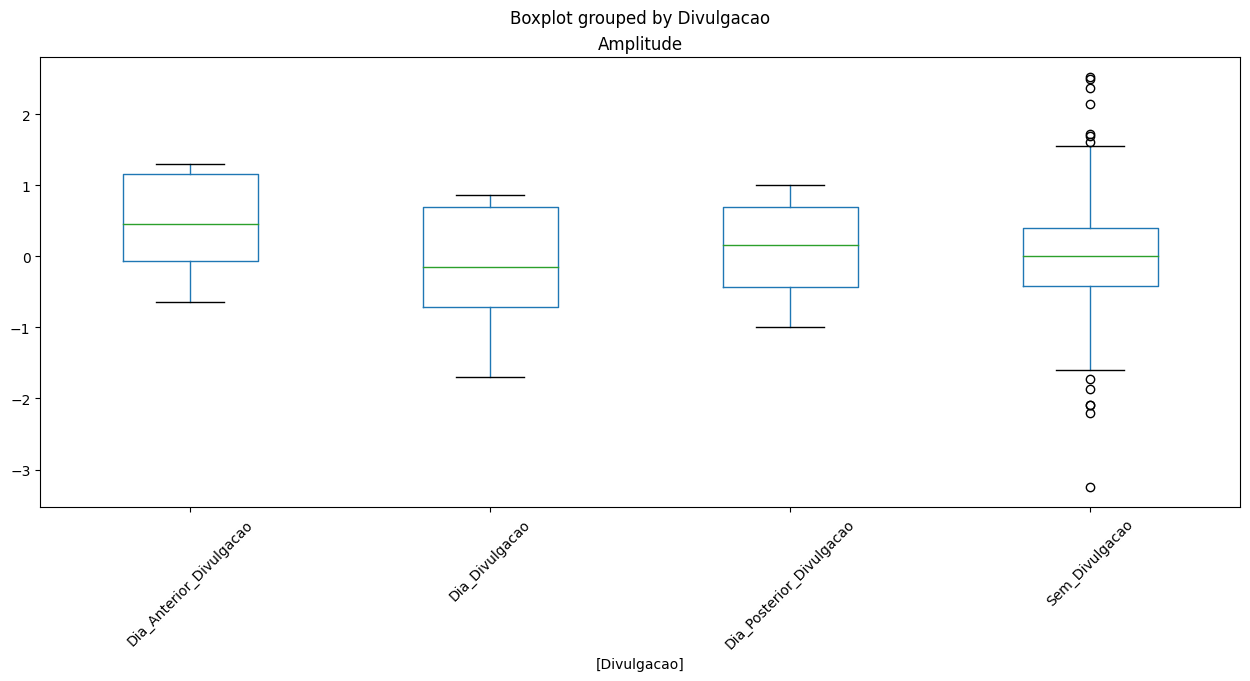

In [12]:
ax = teste_anova1.boxplot(by='Divulgacao', grid = False,figsize=(15,6))
plt.xticks(rotation=45)

In [13]:
modelo1 = ols('Amplitude ~ Divulgacao * Nome_Papel', data = teste_anova1).fit()
resultado1 = sm.stats.anova_lm(modelo1)
resultado1

,df,sum_sq,mean_sq,F,PR(>F)
Divulgacao,3.0,1.915198,0.638399,1.356696,0.255069
Nome_Papel,1.0,1.047244,1.047244,2.225554,0.136261
Divulgacao:Nome_Papel,3.0,0.965889,0.321963,0.684220,0.561911
Residual,610.0,287.038234,0.470554,NaN,NaN


O Pvalor ficou acima do nível de significância em todos os testes, o que indica que não existe evidência estatística suficiente para rejeição de H0



## Teste 2

 ### Hipóteses

  H0 = Não existe diferença de variação da amplitude das ações em relação ao dia até a divulgação

  H1 = Existem diferenças de variação da amplitude das ações em relação ao dia até a divulgação

In [14]:
teste_anova2 = df[['Amplitude','Ate_Divulgacao','Nome_Papel']]
teste_anova2.loc[teste_anova2['Ate_Divulgacao'] < 0, 'Ate_Divulgacao'] = pd.NA
teste_anova2 = teste_anova2.dropna(subset=['Ate_Divulgacao'])


modelo2 = ols('Amplitude ~ Ate_Divulgacao * Nome_Papel', data = teste_anova2).fit()
resultado2 = sm.stats.anova_lm(modelo2)
resultado2

,df,sum_sq,mean_sq,F,PR(>F)
Nome_Papel,1.0,1.026671,1.026671,2.174385,0.140859
Ate_Divulgacao,1.0,0.086780,0.086780,0.183791,0.668292
Ate_Divulgacao:Nome_Papel,1.0,0.423417,0.423417,0.896755,0.344041
Residual,590.0,278.577926,0.472166,NaN,NaN


Da mesma maneira que o teste anterior o Pvalor ficou alto, apontando que não existe evidência estatística o suficiente para rejeitar H0

# Series Temporais

Ao realizar o ANOVA não foi possível encontrar envidência estatística de que existe diferenças nos dias de divulgação do balanço. Porém via análise gráfica foi possível notar que em dias que não tem divulgação existe uma variabilidade maior na amplitude dos preços das ações. Por isso será trabalhado um modelo de série temporal para que seja possível prever essa variação em relação ao tempo.

##DIVULGAÇÕES DE BALANÇOS